# Ottimizzazione dei parametri

In [171]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import random
from statistics import mean 
import itertools
import ga 
import math
path_file="https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
dataset=pd.read_csv(path_file,parse_dates=['data'])

# guariti,infetti,sani, morti 
dataset['asintomatici']= dataset['totale_casi'] * 0.44 
dataset['immuni'] = dataset['dimessi_guariti'] * 0.05  #verificare proporzione
data=dataset[['totale_positivi','dimessi_guariti','deceduti','asintomatici','immuni']]


def initializeParameters(minimo,massimo,n=9):
        return tuple([random.uniform(minimo,massimo) for i in range(0,n)])

def deriv(y,t,k1,k2,k3,k4,k5,k6,k7,k8,k9):  
    '''set di equazioni differenziali'''
    Sani            =   y[0]
    Infetti         =   y[1]
    Asintomatici    =   y[2]
    Morti           =   y[3]
    Guariti         =   y[4]
    Immuni          =   y[5]
    dSanidt =  -k1*Sani*Infetti -k2*Sani*Infetti-k3*Sani*Asintomatici- k4*Sani*Asintomatici
    dInfettidt = k1*Sani*Infetti+k4*Sani-k6*Infetti-k7*Infetti
    dAsintomaticidt =k2*Sani*Infetti+k3*Sani*Asintomatici-k5*Asintomatici
    dMortidt=k6*Infetti
    dGuaritidt = k5*Asintomatici+k7*Infetti-k8*Guariti-k9*Guariti
    dImmunidt = k9*Guariti
    return [dSanidt,dInfettidt,dAsintomaticidt,dMortidt,dGuaritidt,dImmunidt]

def perturbazione(ls):
    sup = 0.2
    for i in range(len(ls)):
        if ls[i] < 0.5:
            ls[i]=random.uniform(ls[i],ls[i]+sup)
        else:
            ls[i]=random.uniform(0,ls[i]-sup)
    return(ls)

def diffusione(parameters,Sani =1-1e-6, Infetti=1e-6,Guariti=0, Morti= 0,Immuni = 0,Asintomatici=0,orizzonte_temporale_in_gg=data.shape[0]):
        y0 =  (Sani,Infetti,Asintomatici,Morti,Guariti,Immuni)
        t = np.arange(0,orizzonte_temporale_in_gg+1)
        ret = odeint(deriv, y0, t,args=tuple(parameters))
        return(ret)

def fitness(previsti):
        df=pd.DataFrame(previsti,columns=['sani','totale_positivi','dimessi_guariti','deceduti','asintomatici','immuni'])
        df=df.drop(columns=['sani'])
        dataframe=((df-data)**2)
        lista=dataframe.values.tolist()
        merged = list(itertools.chain.from_iterable(lista))
        media=mean(merged)
        return media 

def localsearch(iniziale,iterazioni,minimo,massimo,param_only=True):
        #list(initializeParameters(minimo,massimo))
        k=iniziale.copy()
        errore= math.inf
        val='1'
        set_ottimo=[]
        for c in range(iterazioni):
            valori=diffusione(tuple(k))
            stimaerrore=fitness(valori)
            if stimaerrore<errore:
                errore=stimaerrore
                val=valori 
                set_ottimo=iniziale
            iniziale = list(initializeParameters(minimo,massimo))
            k=iniziale.copy()
        if param_only==True : 
            return set_ottimo
        else : 
            return (set_ottimo,val,errore)

def ils(iterazioni=10,minimo=0.00001,massimo=0.001,param_only=True):
        iniziale = list(initializeParameters(minimo,massimo))
        loc_search = localsearch(iniziale,iterazioni,minimo,massimo,param_only=False)
        k=loc_search[0]
        best_val = loc_search[1]
        best_errore = loc_search[2]
        val=0
        for c in range(iterazioni):
            val=best_val
            nuova_iniziale = perturbazione(k)
            loc_search = localsearch(nuova_iniziale,iterazioni,minimo,massimo,param_only=False)
            val = loc_search[1]
            if loc_search[2] < best_errore: # Se nuovo errore minore best si aggiorna il best
                best_errore = loc_search[2]
                best_val= loc_search[1]
                k=loc_search[0]
        if param_only == True : 
            return k
        else : return k,best_val,best_errore  




In [49]:
ils()

[0.28631806517741815,
 0.08379106292299272,
 0.35632564539013395,
 0.4928745441424222,
 0.16700924299800604,
 0.18589290088107546,
 0.4526659972145615,
 0.18295030029963563,
 0.38857911167472464]

# Dinamica

In [151]:

parametri_ottimi = ils(iterazioni=20)
parametri_ottimi=[0.2841767644552877, 0.10239098966633194, 0.4092331630339743, 0.27271073435039006, 0.34618334431404524, 0.4691470097791906, 0.15084401130189823, 0.44502706348620036, 0.1954547882561599]

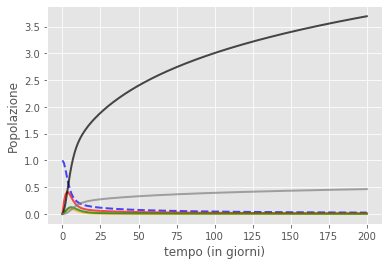

In [174]:
ret=diffusione(parametri_ottimi,orizzonte_temporale_in_gg=200)
plt.plot(ret[:,0], 'b--', alpha=0.7 ,lw=2, label='Sani')
plt.plot(ret[:,1], 'r', alpha=0.7 ,lw=2, label='Infetti')
plt.plot(ret[:,2], 'orange', alpha=0.7 ,lw=2, label='Asintomatici')
plt.plot(ret[:,3], 'k', alpha=0.7 ,lw=2, label='Morti')
plt.plot(ret[:,4], 'g', alpha=0.7 ,lw=2, label='Guariti')
plt.plot(ret[:,5], 'grey', alpha=0.7 ,lw=2, label='Immuni')
plt.xlabel('tempo (in giorni)')
plt.ylabel('Popolazione')
plt.show()

In [181]:
ret[:,3]

array([0.        , 0.05679314, 0.19813593, 0.38176668, 0.57316137,
       0.750691  , 0.90493242, 1.03456012, 1.14224761, 1.23197187,
       1.30764155, 1.37256262, 1.42933107, 1.47990462, 1.52572783,
       1.56785585, 1.6070577 , 1.64389589, 1.67878517, 1.71203488,
       1.74387896, 1.77449715, 1.80402993, 1.83258908, 1.86026508,
       1.8871325 , 1.91325379, 1.93868204, 1.96346306, 1.98763686,
       2.01123874, 2.03430022, 2.05684962, 2.07891261, 2.1005126 ,
       2.12167105, 2.14240772, 2.1627409 , 2.18268756, 2.20226351,
       2.2214835 , 2.24036136, 2.25891003, 2.27714171, 2.29506785,
       2.31269928, 2.33004622, 2.34711834, 2.36392477, 2.38047422,
       2.39677492, 2.41283469, 2.428661  , 2.44426093, 2.45964125,
       2.47480842, 2.48976858, 2.50452763, 2.5190912 , 2.53346466,
       2.54765319, 2.56166172, 2.57549498, 2.58915754, 2.60265375,
       2.61598783, 2.6291638 , 2.64218556, 2.65505682, 2.6677812 ,
       2.68036214, 2.69280301, 2.70510702, 2.71727728, 2.72931

In [ ]:
 dSanidt =  -k1*Sani*Infetti -k2*Sani*Infetti-k3*Sani*Asintomatici- k4*Sani*Asintomatici
    dInfettidt = k1*Sani*Infetti+k4*Sani-k6*Infetti-k7*Infetti
    dAsintomaticidt =k2*Sani*Infetti+k3*Sani*Asintomatici-k5*Asintomatici
    dMortidt=k6*Infetti
    dGuaritidt = k5*Asintomatici+k7*Infetti-k8*Guariti-k9*Guariti
    dImmunidt = k9*Guariti

In [162]:
np.arange(0,100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])